In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from score_model import *
from gameover_model import *
import cv2
import pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
import gc

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import tensorflow as tf
from tqdm import tqdm

In [7]:
score_model = generate_scoring_model()
time_model = generate_time_model()
position_score_model = generate_position_model()

In [8]:
import pickle

def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)

def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [9]:
def process_img(image, sigma=0.4):
	# compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

In [10]:
def model_capture_return_images(images): 
    
    # predict command
    imgs = np.array(images).astype(np.uint8)
    #imgs = np.expand_dims(imgs, axis=0)
    imgs = np.swapaxes(imgs,0,1)
    imgs = np.swapaxes(imgs,1,2)
    #print('model_capture_return_images shape',imgs.shape)
    return imgs

def prepare_db(queue,epoch=1):
    
    score_model = generate_scoring_model()
    position_score_model = generate_position_model()
    
    #Applying Q-Learning
    # learning rate - in reinforcement learning, this is gamma
    LR = 0.5 * (1 - ((epoch-1)/1000))
    
    if LR < 0.1:
        LR = 0.1
    
    actions = []
    frame_imgs = []
    score = []
    score_points = []
    score_position = []
    time = []
    
    #print('Starting to organize data before training... Nº', 0, 'of', len(queue),'samples.', end='\r')
    for i in tqdm(np.arange(5,len(queue)-5,1)):
        if queue[i][1][:4] != [1,0,0,0]:
            #print('Starting to organize data before training... Nº', i, 'of', len(queue),'samples.', end='\r')
            #frame_imgs.append(model_capture_return_images([j[0][100:,:] for j in queue[i-5:i]]))
            frame_imgs.append(model_capture_return_images( [ process_img(j[0][120:,60:270]) for j in queue[i-5:i]]))
            # ['a', 'b', 'r', 'l', 'g'][:4]
            actions.append(queue[i][1][:4])
            # appending score
            score_i = return_score(queue[i][0],score_model)
            score_f = return_score(queue[i+5][0],score_model)
            position = return_position_score(queue[i+5][0],position_score_model)
            score_points.append(np.clip(score_f-score_i,0,10000))
            score_position.append(position[0])

            time.append(queue[i+5][2]-queue[i][2])
            # Q - Learning Happening Here
            score.append(np.clip((score_points[-1]/10000) if score_points[-1] > 100 else -0.5, -0.5, 1)+np.clip(1 if score_position[0] > 0.6 else 0,0,1))
            
            
            
        elif np.random.rand() > 0.3:
            #print('Starting to organize data before training... Nº', i, 'of', len(queue),'samples.', end='\r')
            #frame_imgs.append(model_capture_return_images([j[0][100:,:] for j in queue[i-5:i]]))
            frame_imgs.append(model_capture_return_images( [ process_img(j[0][120:,60:270]) for j in queue[i-5:i]]))
            # ['a', 'b', 'r', 'l', 'g'][:4]
            actions.append(queue[i][1][:4])
            # appending score
            score_i = return_score(queue[i][0],score_model)
            score_f = return_score(queue[i+5][0],score_model)
            position = return_position_score(queue[i+5][0],position_score_model)
            score_points.append(np.clip(score_f-score_i,0,10000))
            score_position.append(position[0])

            time.append(queue[i+5][2]-queue[i][2])
            # Q - Learning Happening Here
            score.append(np.clip((score_points[-1]/10000) if score_points[-1] > 100 else -0.5, -0.5, 1)+np.clip(1 if score_position[0] > 0.6 else 0,0,1))
        
    
    print('\n')
    print('Learning Rate: '+str(LR)+'.\n')
    print('Sample has ' + str(len(queue)) + ' training samples.\n')
    print('Mean time between samples: '+ str(np.mean(time)) + ' sec.\n')
    print('Mean Score between samples: ' + str(np.mean(score)) + ' points.\n')
    print('Mean Score Points between samples: ' + str(np.mean(score_points)) + ' points.\n')
    print('Mean Score Position between samples: ' + str(np.mean(score_position)) + ' points.\n')
    print('Maximum Train Score: ' + str(return_score(queue[-1][0],score_model))+'.\n')
    print('Maximum Delta Score: ' + str(max(score)) + '.\nMinimum Delta Score:' + str(min(score))+'.\n')
    print('\n')
    
    # pre trained model
    frame_imgs = np.array(frame_imgs)
    actions = np.array(actions)
    
    return frame_imgs, actions, score, score_points, score_position

In [11]:
files = ['fila_treino_segundo_132_0_.pkl','fila_treino_segundo_601_0_.pkl',
         'fila_treino_segundo_601_1_.pkl','fila_treino_segundo_601_2_.pkl',
         'fila_treino_segundo_601_3_.pkl','fila_treino_segundo_601_4_.pkl',
         'fila_treino_segundo_601_5_.pkl','fila_treino_segundo_601_6_.pkl',
         'fila_treino_segundo_74_0_.pkl']

In [12]:
queue = []
for file in files:
    print(file)
    q = load_file('./ANALYSE_DATA/'+file)
    queue = queue + q


fila_treino_segundo_132_0_.pkl
fila_treino_segundo_601_0_.pkl
fila_treino_segundo_601_1_.pkl
fila_treino_segundo_601_2_.pkl
fila_treino_segundo_601_3_.pkl
fila_treino_segundo_601_4_.pkl
fila_treino_segundo_601_5_.pkl
fila_treino_segundo_601_6_.pkl
fila_treino_segundo_74_0_.pkl


In [13]:
del q
gc.collect()

22

In [14]:
frame_imgs, actions, score, score_points, score_position = prepare_db(queue)

100%|████████████████████████████████████████████████████████████████████████████| 32139/32139 [19:15<00:00, 27.82it/s]




Learning Rate: 0.5.

Sample has 32149 training samples.

Mean time between samples: 0.6828761941263226 sec.

Mean Score between samples: 1.3010324084269251 points.

Mean Score Points between samples: 3216.602804081333 points.

Mean Score Position between samples: 0.8951152 points.

Maximum Train Score: 1427840.

Maximum Delta Score: 2.0.
Minimum Delta Score:0.5.





In [15]:
frame_imgs.shape

(27246, 100, 210, 5)

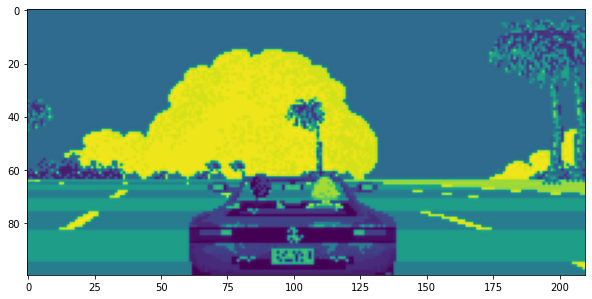

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(queue[2000][0][120:,60:270])

In [17]:
queue[2000][1]

[1, 0, 0, 1, 0]

In [18]:
del queue
gc.collect()

13741

#### Creating DataFrame

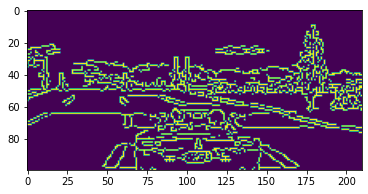

In [19]:
plt.imshow(frame_imgs[350,:,:,0])

Arrumando Comandos


In [21]:
com_1 = []
com_2 = []
for act in actions:
    
    if act[0] == 1 and act[1] == 0:
        com_1.append([1,0,0])
    elif act[0] == 0 and act[1] == 1:
        com_1.append([0,1,0])
    else:
        com_1.append([0,0,0])
        
    if act[2] == 1 and act[3] == 0:
        com_2.append([1,0,0])
    elif act[2] == 0 and act[3] == 1:
        com_2.append([0,1,0])
    else:
        com_2.append([0,0,0])

In [27]:
com_accbrake = np.array(com_1)
com_rightleft = np.array(com_2)

In [61]:
com_accbrake.shape, com_rightleft.shape, np.array([com_accbrake,com_rightleft]).shape

((27246, 3), (27246, 3), (2, 27246, 3))

# Modelo

In [28]:
#input_shape = (img_rows, img_cols, 1)
input_shape = (frame_imgs.shape[1], frame_imgs.shape[2], 5)
num_classes = 3
batch_size = 256
epochs = 5 #600
input_shape,num_classes

((100, 210, 5), 3)

In [30]:
input_0 = tf.keras.layers.Input(shape=input_shape)
input_1 = tf.keras.layers.Lambda(lambda x: x/255)(input_0)
conv_2d_1  = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(1, 3))(input_1)
batch_1 = tf.keras.layers.BatchNormalization()(conv_2d_1)
actv_1 = tf.keras.layers.Activation('relu')(batch_1)
drop_1 = tf.keras.layers.Dropout(rate=0.5)(actv_1)
max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop_1)
conv_2d_2 = tf.keras.layers.Conv2D(32, kernel_size=(10, 10), strides=(2, 2))(max_1)
batch_2 = tf.keras.layers.BatchNormalization()(conv_2d_2)
actv_2 = tf.keras.layers.Activation('relu')(batch_2)
drop_2 = tf.keras.layers.Dropout(rate=0.5)(actv_2)
max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop_2)
conv_2d_3 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2))(max_2)
batch_3 = tf.keras.layers.BatchNormalization()(conv_2d_3)
actv_3 = tf.keras.layers.Activation('relu')(batch_3)
drop_3 = tf.keras.layers.Dropout(rate=0.5)(actv_3)
flatt = tf.keras.layers.Flatten()(drop_3)
dense_1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4),activity_regularizer=tf.keras.regularizers.l2(1e-5))(flatt)
drop_4 = tf.keras.layers.Dropout(rate=0.5)(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4),activity_regularizer=tf.keras.regularizers.l2(1e-5))(drop_4)
drop_5 = tf.keras.layers.Dropout(rate=0.5)(dense_2)
outs = [ tf.keras.layers.Dense(3,activation='linear',name='output_accbrake')(drop_5), tf.keras.layers.Dense(3,activation='linear',name='output_rightleft')(drop_5)]
model = tf.keras.Model(inputs=input_0, outputs=outs)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 210, 5) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 100, 210, 5)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 81, 64, 64)   128064      lambda_6[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 81, 64, 64)   256         conv2d_14[0][0]                  
______________________________________________________________________________________________

In [33]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,frame_imgs.shape[0]),range(0,frame_imgs.shape[0]), test_size=0.05, random_state=42)

In [34]:
#model.compile(loss=keras.losses.binary_crossentropy,
#              optimizer=keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs),
#              metrics=['accuracy'])
INIT_LR = 1e-2
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['mse','mae'])

In [35]:
gc.collect()

783

In [36]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_encoded_learning_best_mse.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(frame_imgs[X_train,:,:,:], [com_accbrake[X_train],com_rightleft[X_train]],
          batch_size=batch_size,
          epochs=epochs,
          shuffle = True,
          validation_data=(frame_imgs[X_test,:,:,:], [com_accbrake[X_test],com_rightleft[X_test]]),
          callbacks=[mcp_save, earlyStopping])

Train on 25883 samples, validate on 1363 samples
Epoch 1/5
25883/25883 [==============================] - ETA: 20:49 - loss: 4.5845 - output_accbrake_loss: 2.9226 - output_rightleft_loss: 1.6295 - output_accbrake_mse: 2.9226 - output_accbrake_mae: 1.3740 - output_rightleft_mse: 1.6295 - output_rightleft_mae: 0.972 - ETA: 10:58 - loss: 4.1614 - output_accbrake_loss: 2.5131 - output_rightleft_loss: 1.6160 - output_accbrake_mse: 2.5131 - output_accbrake_mae: 1.2614 - output_rightleft_mse: 1.6160 - output_rightleft_mae: 0.972 - ETA: 7:33 - loss: 3.7872 - output_accbrake_loss: 2.1924 - output_rightleft_loss: 1.5626 - output_accbrake_mse: 2.1924 - output_accbrake_mae: 1.1777 - output_rightleft_mse: 1.5626 - output_rightleft_mae: 0.959 - ETA: 5:51 - loss: 3.4842 - output_accbrake_loss: 1.9830 - output_rightleft_loss: 1.4690 - output_accbrake_mse: 1.9830 - output_accbrake_mae: 1.1174 - output_rightleft_mse: 1.4690 - output_rightleft_mae: 0.93 - ETA: 4:49 - loss: 3.2603 - output_accbrake_loss: 

In [37]:
model_json = model.to_json()
with open("./modelo_outrun_naec.json", "w") as json_file:
    json_file.write(model_json)

In [38]:
model.save_weights("D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_naec.hdf5")

In [39]:
model.save("D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_naec")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_naec\assets


In [41]:
score_model = model.evaluate(frame_imgs[X_test,:,:,:], [com_accbrake[X_test],com_rightleft[X_test]] , verbose=0)
print('Test loss:', score[0])

Test loss: 0.5


In [50]:
model.predict(np.expand_dims(frame_imgs[100,:,:,:],axis=0))

[array([[ 0.6202976 , -0.02621913,  0.05224115]], dtype=float32),
 array([[0.1731682 , 0.20346212, 0.00298833]], dtype=float32)]

In [58]:
model.predict(np.expand_dims(frame_imgs[i,:,:,:],axis=0))[0][0]

array([ 0.6123715 , -0.02442207,  0.05118811], dtype=float32)

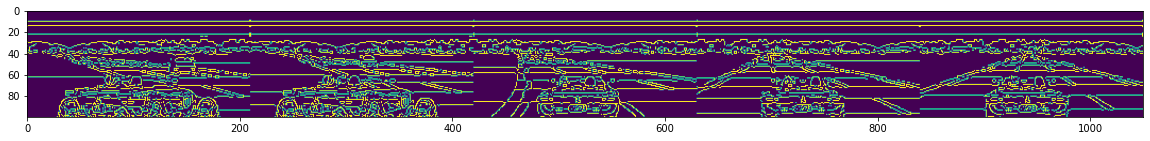

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.18, 0.02]], dtype=float32)]
Soma 1.012989


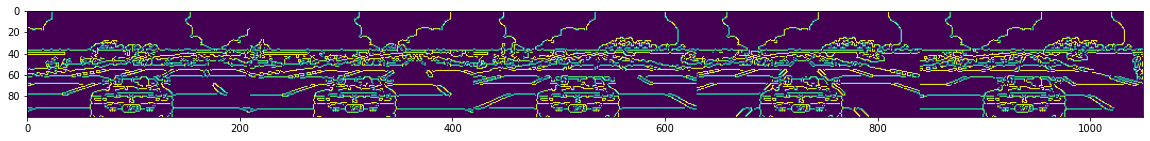

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.19, 0.18, 0.02]], dtype=float32)]
Soma 1.0333173


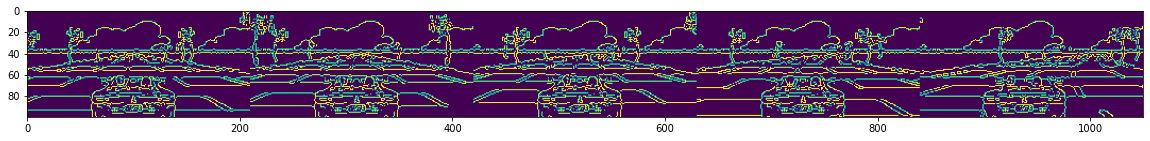

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.63, -0.03,  0.05]], dtype=float32), array([[0.19, 0.17, 0.03]], dtype=float32)]
Soma 1.026867


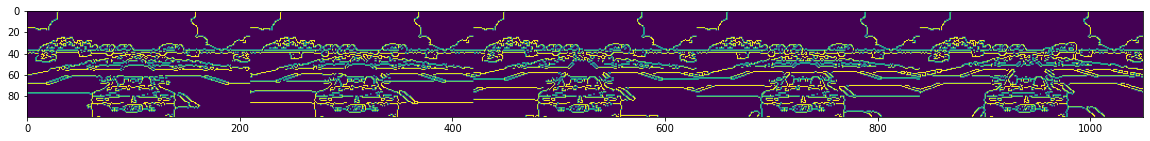

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.17, 0.02]], dtype=float32)]
Soma 1.0106003


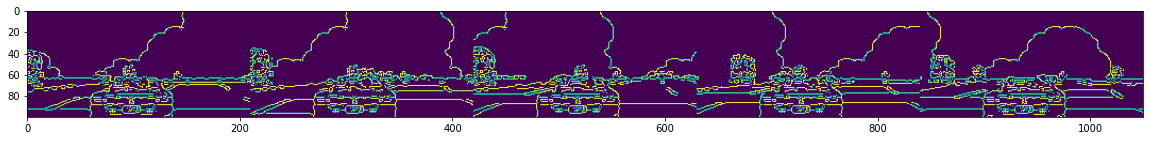

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.17, 0.21, 0.  ]], dtype=float32)]
Soma 1.0188826


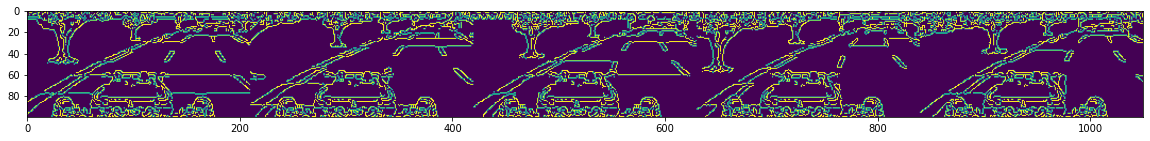

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.61, -0.03,  0.05]], dtype=float32), array([[0.17, 0.2 , 0.01]], dtype=float32)]
Soma 1.0100296


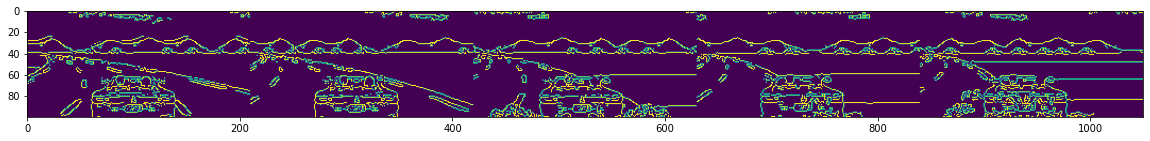

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.6 , -0.02,  0.05]], dtype=float32), array([[0.17, 0.19, 0.  ]], dtype=float32)]
Soma 0.99846834


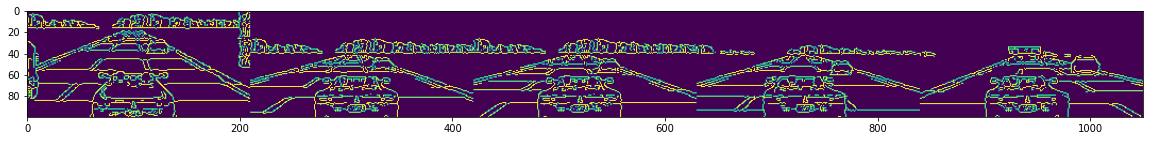

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.19, 0.01]], dtype=float32)]
Soma 1.0196825


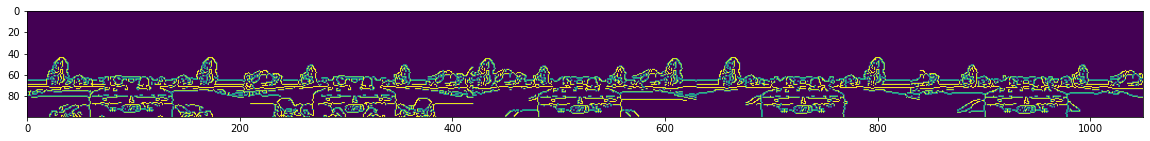

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.6 , -0.03,  0.05]], dtype=float32), array([[ 0.17,  0.2 , -0.  ]], dtype=float32)]
Soma 1.0063014


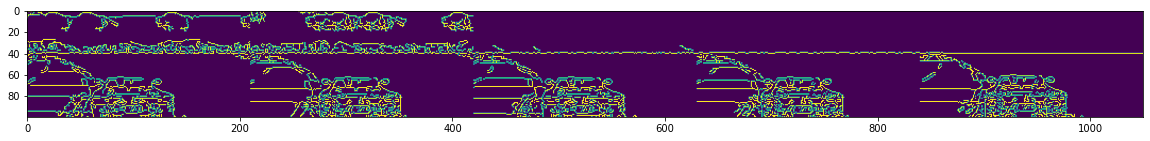

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.61, -0.03,  0.05]], dtype=float32), array([[0.17, 0.19, 0.01]], dtype=float32)]
Soma 1.0070182


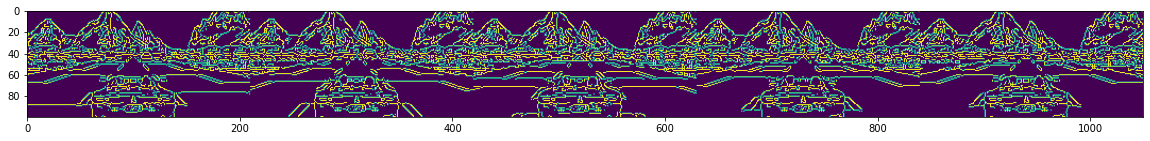

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.57, -0.02,  0.06]], dtype=float32), array([[0.17, 0.18, 0.  ]], dtype=float32)]
Soma 0.96013665


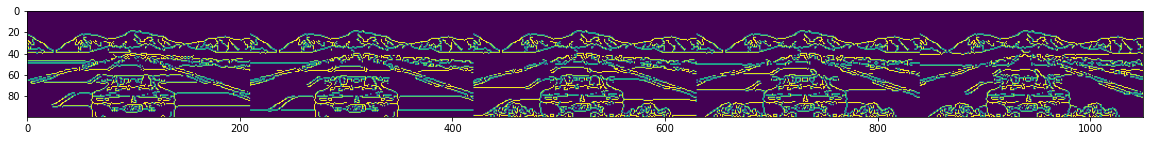

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.61, -0.03,  0.05]], dtype=float32), array([[0.18, 0.19, 0.01]], dtype=float32)]
Soma 1.0031104


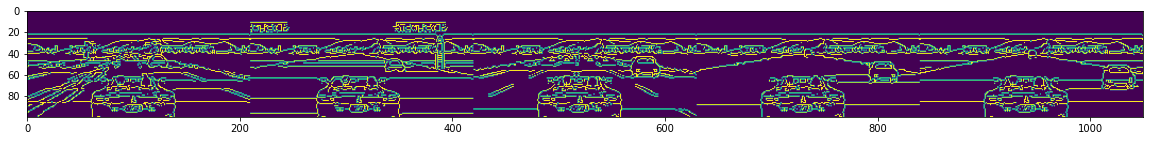

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.6 , -0.02,  0.05]], dtype=float32), array([[0.17, 0.18, 0.01]], dtype=float32)]
Soma 0.9836816


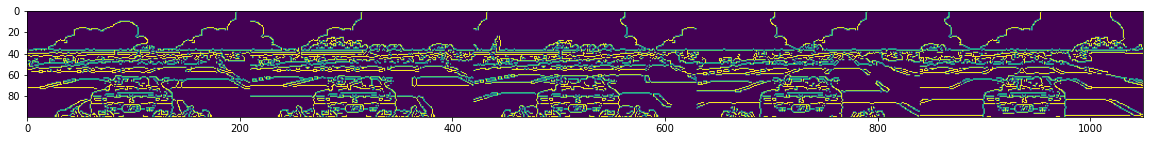

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.19, 0.17, 0.02]], dtype=float32)]
Soma 1.0184102


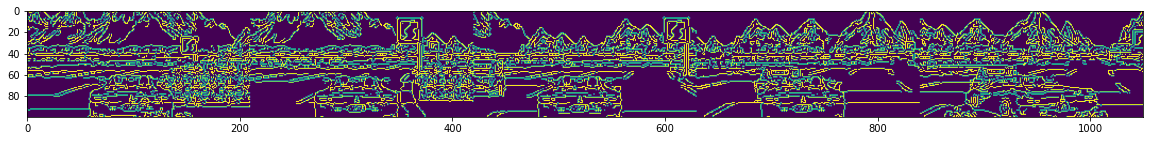

[array([0, 0, 0]), array([0, 0, 0])]
[array([[ 0.59, -0.02,  0.05]], dtype=float32), array([[0.17, 0.18, 0.  ]], dtype=float32)]
Soma 0.98136234


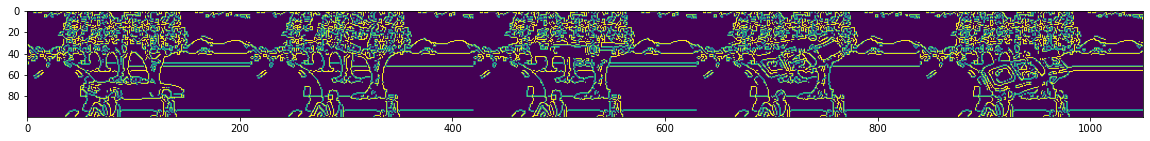

[array([0, 0, 0]), array([0, 0, 0])]
[array([[ 0.59, -0.03,  0.04]], dtype=float32), array([[0.18, 0.19, 0.01]], dtype=float32)]
Soma 0.9847274


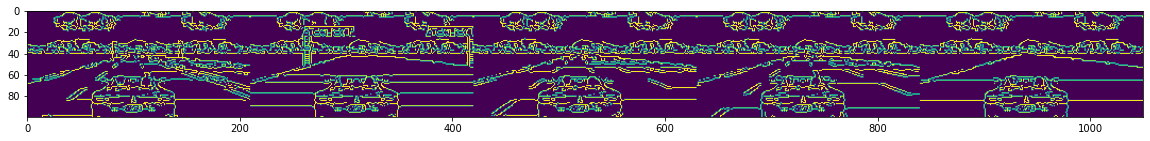

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.61, -0.02,  0.05]], dtype=float32), array([[0.17, 0.17, 0.02]], dtype=float32)]
Soma 1.0042888


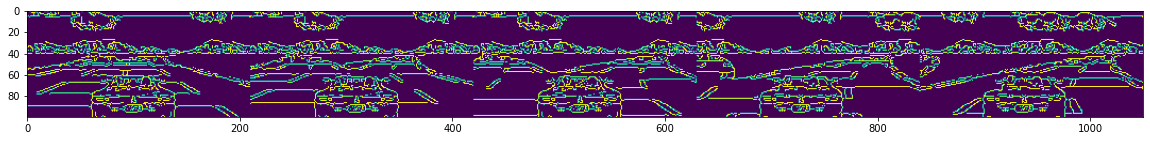

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.61, -0.02,  0.05]], dtype=float32), array([[0.17, 0.18, 0.01]], dtype=float32)]
Soma 1.0018734


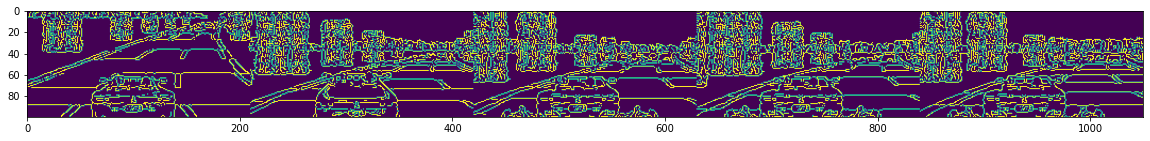

[array([0, 0, 0]), array([1, 0, 0])]
[array([[ 0.58, -0.02,  0.06]], dtype=float32), array([[0.17, 0.17, 0.  ]], dtype=float32)]
Soma 0.9602996


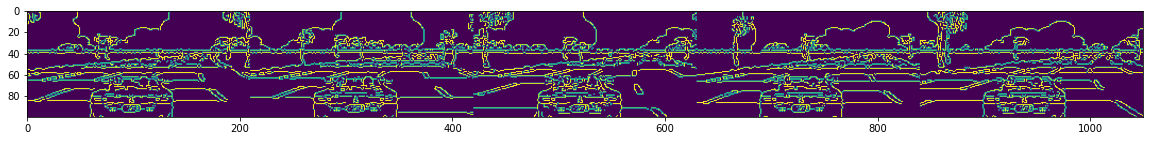

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.17, 0.02]], dtype=float32)]
Soma 1.0189886


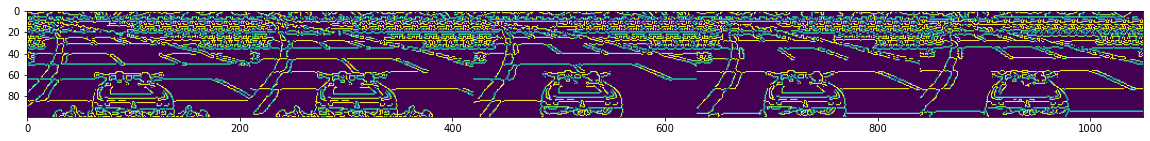

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.6 , -0.02,  0.06]], dtype=float32), array([[ 0.18,  0.21, -0.01]], dtype=float32)]
Soma 1.0062319


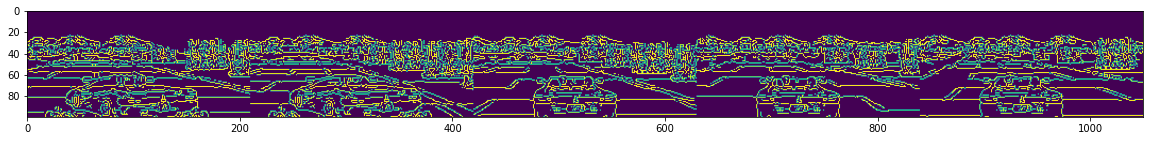

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.58, -0.02,  0.05]], dtype=float32), array([[ 0.18,  0.18, -0.  ]], dtype=float32)]
Soma 0.9670317


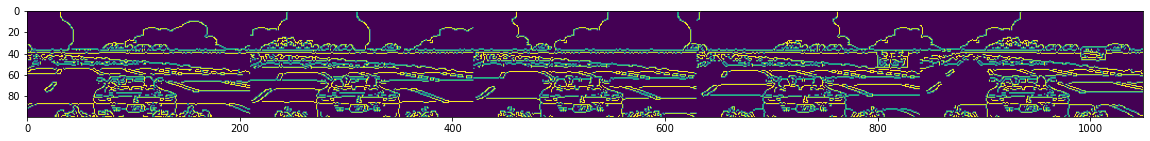

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.18, 0.02]], dtype=float32)]
Soma 1.0175095


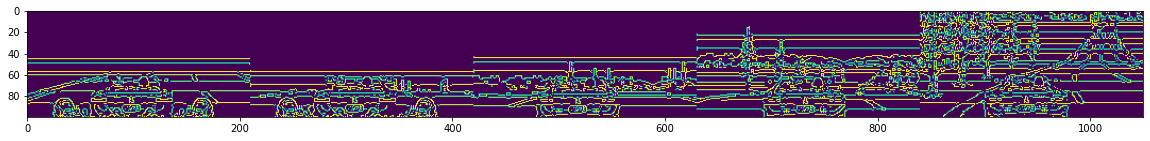

[array([1, 0, 0]), array([1, 0, 0])]
[array([[ 0.63, -0.03,  0.05]], dtype=float32), array([[0.18, 0.2 , 0.01]], dtype=float32)]
Soma 1.0456395


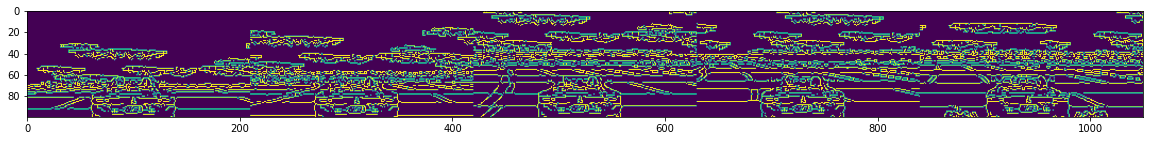

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.18, 0.18, 0.02]], dtype=float32)]
Soma 1.0138719


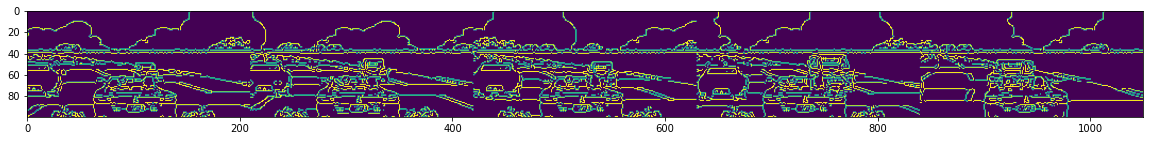

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.17, 0.19, 0.01]], dtype=float32)]
Soma 1.0142511


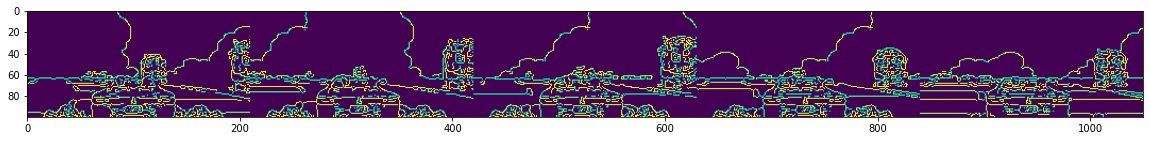

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.62, -0.03,  0.05]], dtype=float32), array([[0.17, 0.2 , 0.01]], dtype=float32)]
Soma 1.01798


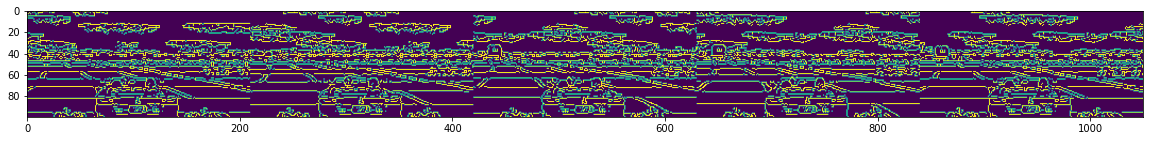

[array([1, 0, 0]), array([0, 1, 0])]
[array([[ 0.6 , -0.03,  0.05]], dtype=float32), array([[0.18, 0.18, 0.01]], dtype=float32)]
Soma 0.9937942


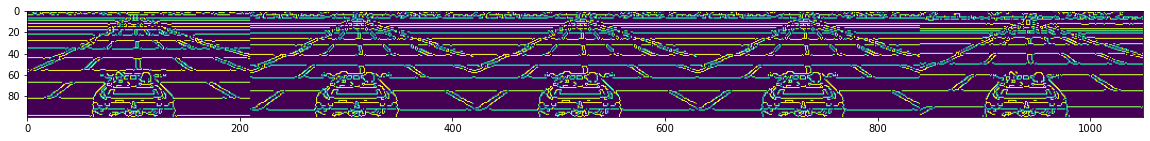

[array([1, 0, 0]), array([0, 0, 0])]
[array([[ 0.6 , -0.02,  0.05]], dtype=float32), array([[ 0.17,  0.19, -0.  ]], dtype=float32)]
Soma 0.98924804


In [52]:
for i in range(0,frame_imgs.shape[0]):
    if np.random.rand() < 0.001:
        plt.figure(figsize=(20,20))
        plt.imshow(np.hstack(np.array([frame_imgs[i,:,:,0],frame_imgs[i,:,:,1],frame_imgs[i,:,:,2],frame_imgs[i,:,:,3],frame_imgs[i,:,:,4]])))
        plt.show()
        print([com_accbrake[i],com_rightleft[i]])
        print([np.round(i,2) for i  in model.predict(np.expand_dims(frame_imgs[i,:,:,:],axis=0))])
        print('Soma',np.sum(model.predict(np.expand_dims(frame_imgs[i,:,:,:],axis=0))))